<a href="https://colab.research.google.com/github/jeremyliweishih/150-DNN-Final/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File setup from Github:

In [0]:
!pip install -q xlrd
!rm -f -r 150-DNN-Final
!git clone https://github.com/jeremyliweishih/150-DNN-Final
#test

Cloning into '150-DNN-Final'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 132 (delta 9), reused 11 (delta 5), pack-reused 97
Receiving objects: 100% (132/132), 1.87 MiB | 12.88 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [0]:
# Files from the cloned git repository.
!ls 150-DNN-Final/

BBB  BCNN-BBB.ipynb  README.md


In [0]:
#need to upload kaggle auth token
from google.colab import files
files.upload()

In [0]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000  

100% 2.61G/2.62G [00:27<00:00, 115MB/s] 
100% 2.62G/2.62G [00:27<00:00, 104MB/s]


In [0]:
!unzip skin-cancer-mnist-ham10000.zip

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: hmnist_28_28_RGB.csv    
  inflating: HAM10000_metadata.csv   
  inflating: HAM10000_images_part_1.zip  
  inflating: hmnist_28_28_L.csv      
  inflating: hmnist_8_8_L.csv        
  inflating: HAM10000_images_part_2.zip  
  inflating: hmnist_8_8_RGB.csv      


In [0]:
!unzip HAM10000_images_part_1.zip
!unzip HAM10000_images_part_2.zip

# Load images: 
loading code creds: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools


In [0]:
base_skin_dir = os.path.join('./', '')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [0]:
#load images and fillna
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['cell_type_idx'] = skin_df['cell_type_idx'].apply(lambda x: int(x))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[189, 149, 186], [192, 154, 193], [199, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 15, 26], [60, 42, 68], [107, 81, 116], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 134, 147], [198, 146, 159], [196, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[32, 16, 27], [88, 57, 73], [128, 80, 96], [..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[153, 111, 133], [189, 143, 172], [208, 158,..."


In [0]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[189, 149, 186], [192, 154, 193], [199, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 15, 26], [60, 42, 68], [107, 81, 116], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 134, 147], [198, 146, 159], [196, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[32, 16, 27], [88, 57, 73], [128, 80, 96], [..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[153, 111, 133], [189, 143, 172], [208, 158,..."


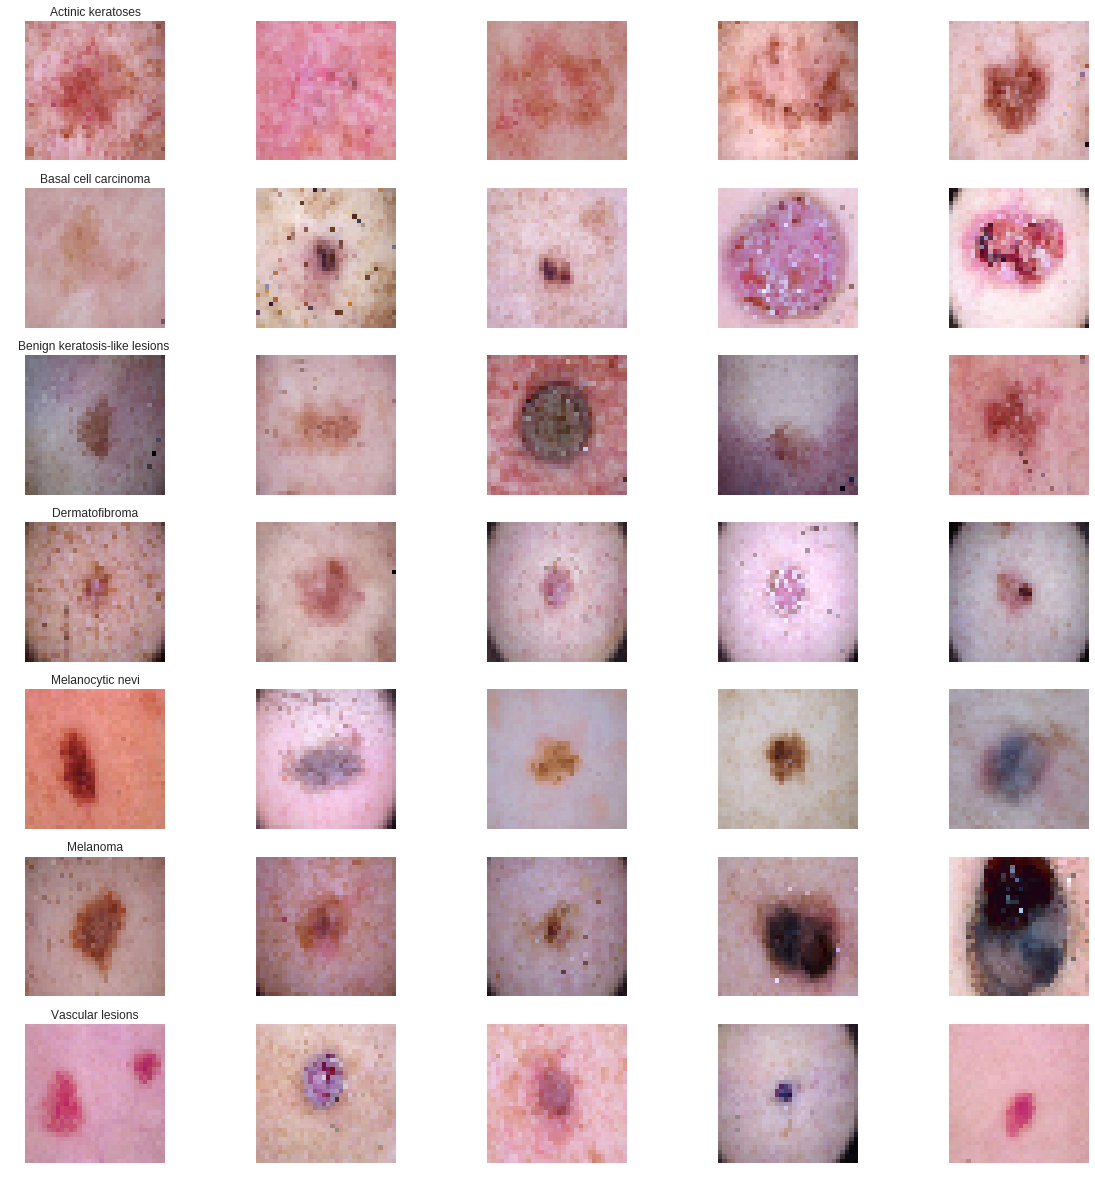

In [0]:
#check samples
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# Pytorch Custom Dataset:

In [0]:
from torch.utils.data.dataset import Dataset
import torchvision
import torchvision.transforms as transforms

class CustomDatasetFromImages(Dataset):
    def __init__(self, df, transforms=None):
        """
        Args:
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Tensor Transform
#         self.to_tensor = transforms.ToTensor()
        self.transforms = transforms
        # Read the csv file
        self.dataset = df
        # 10th column contains the images
        self.image_arr = np.asarray(self.dataset.iloc[:, 10])
        # 9th column is the labels
        self.label_arr = np.asarray(self.dataset.iloc[:, 9])
        # Calculate len
        self.data_len = len(self.dataset.index)

    def __getitem__(self, index):
        # Open image
        img_as_np = self.image_arr[index]
        img_as_img = Image.fromarray(img_as_np)

#         # Transform image to tensor
#         img_as_tensor = self.to_tensor(img_as_img)
        
        if self.transforms:
                  img_as_tensor = self.transforms(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

# Setup NN

In [0]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical


In [0]:
import sys
sys.path.append('/content/150-DNN-Final/BBB/')

from utils.BBBlayers import GaussianVariationalInference
from utils.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from utils.BayesianModels.BayesianAlexNet import BBBAlexNet
from utils.BayesianModels.BayesianLeNet import BBBLeNet
from utils.BayesianModels.BayesianSqueezeNet import BBBSqueezeNet

In [0]:
outputs = 7
inputs = 3
resume = False
n_epochs = 30
lr = 0.001
weight_decay = 0.0005
num_samples = 10
beta_type = "Blundell"
resize=32

use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

In [0]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


In [0]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

train_data, test_data = train_test_split(skin_df, test_size=0.20,random_state=1234)

In [0]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [0]:
train_data.head()
test_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000628,ISIC_0024567,nv,follow_up,35.0,female,lower extremity,./ISIC_0024567.jpg,Melanocytic nevi,4,"[[[208, 115, 133], [211, 119, 142], [212, 122,..."
1,HAM_0004226,ISIC_0032760,nv,histo,25.0,female,trunk,./ISIC_0032760.jpg,Melanocytic nevi,4,"[[[55, 45, 56], [102, 86, 99], [125, 108, 126]..."
2,HAM_0002015,ISIC_0034035,nv,histo,30.0,female,lower extremity,./ISIC_0034035.jpg,Melanocytic nevi,4,"[[[148, 136, 160], [158, 147, 164], [161, 147,..."
3,HAM_0001651,ISIC_0033251,nv,histo,45.0,male,back,./ISIC_0033251.jpg,Melanocytic nevi,4,"[[[117, 103, 120], [129, 115, 130], [131, 117,..."
4,HAM_0003206,ISIC_0025199,bkl,histo,60.0,female,lower extremity,./ISIC_0025199.jpg,Benign keratosis-like lesions,2,"[[[190, 172, 184], [187, 166, 175], [188, 168,..."


In [0]:
train_set = CustomDatasetFromImages(train_data, transforms=transform)
test_set = CustomDatasetFromImages(test_data, transforms=transform)

In [0]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
    num_workers=num_workers)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

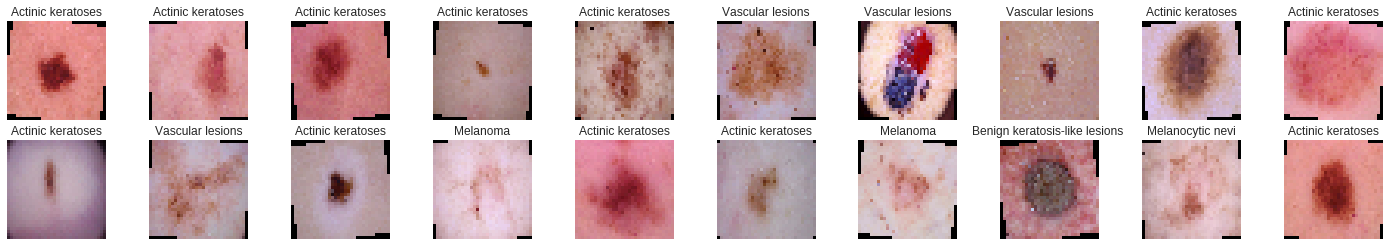

In [0]:
classes = ('Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions ', 'Basal cell carcinoma',
            'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma')

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
net_type = '3conv3fc'
dataset = 'HAM10000'
net = BBB3Conv3FC(outputs,inputs)

In [0]:
use_cuda = torch.cuda.is_available()

if use_cuda:
  net.cuda()

In [0]:
vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [0]:
ckpt_name = f'model_{net_type}_{dataset}_bayesian.pt'
ckpt_name

'model_3conv3fc_HAM10000_bayesian.pt'

In [0]:
torch.cuda.empty_cache()

In [0]:
import math

%time

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    m = math.ceil(len(train_data) / batch_size)
    
    ###################
    # train the model #
    ###################
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item()*data.size(0)) / num_samples
        
    ######################    
    # validate the model #
    ######################
    net.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)
        # update average validation loss 
        valid_loss += (loss.item()*data.size(0)) / num_samples
        
    # calculate average losses
    
    train_loss = train_loss/(len(train_loader.dataset) * (1-valid_size))
    valid_loss = valid_loss/(len(valid_loader.dataset) * valid_size)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), ckpt_name)
        valid_loss_min = valid_loss

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Epoch: 1 	Training Loss: nan 	Validation Loss: nan


KeyboardInterrupt: ignored